<a href="https://colab.research.google.com/github/zawarudobngdev/transfer_learning/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset

A concrete end-to-end transfer learning & fine-tuning example. We will load the Xception model, pre-trained on ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.

### Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS.

Transfer learning is most useful when working with very small datasets. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [ ]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all different sizes.

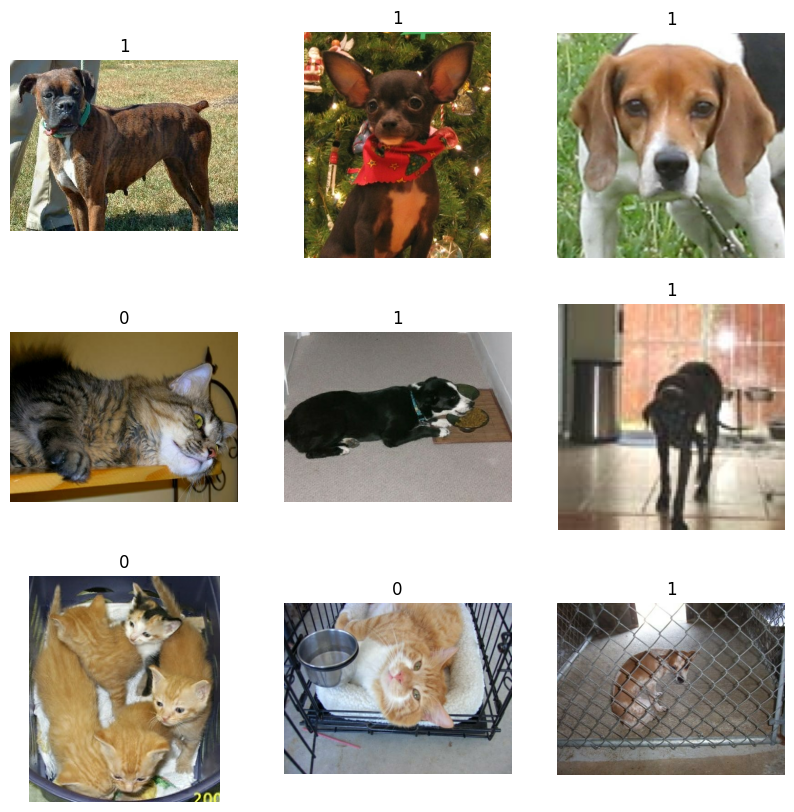

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

We can also see that label 1 is "dog" and label 0 is "cat".

### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for feeding a neural network. We need to do 2 things:

- Standardize to a fixed image size 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a Normalization layer as part of the model itself.

Resizing images to 150x150:

In [ ]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Batch the data and use prefetching to optimize loading speed.

In [ ]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

Visualizing what the first image of the first batch looks like after various random transformations:

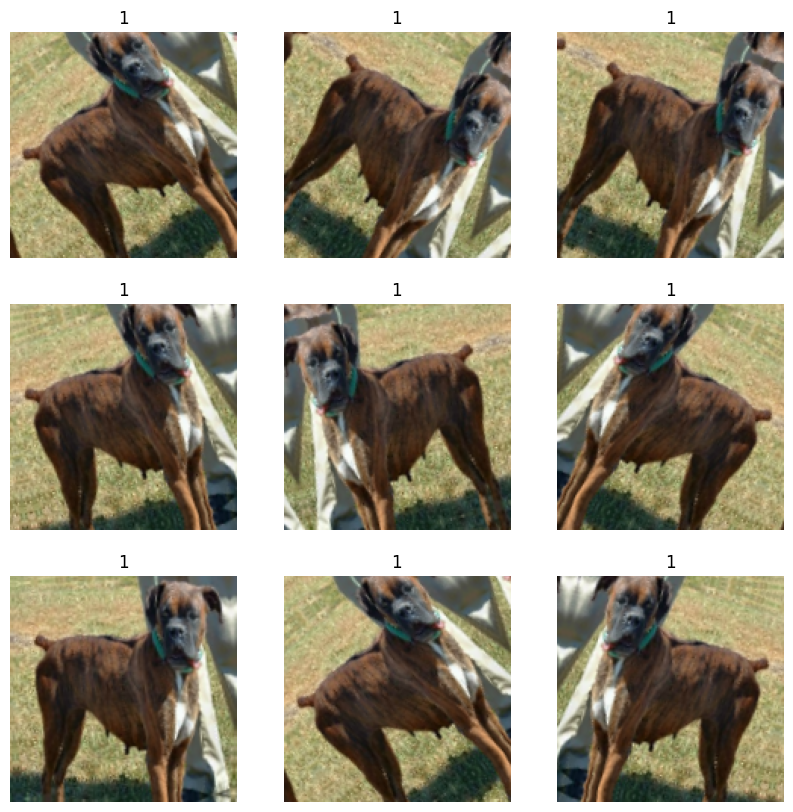

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Build a model

Note that:

- We add a Rescaling layer to scale input values (initially in the [0, 255] range) to the [-1, 1] range.
- We add a Dropout layer before the classification layer, for regularization.
- We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

### Train the top layer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 [==============================] - 67s 386ms/step - loss: 0.1903 - binary_accuracy: 0.9163 - val_loss: 0.0871 - val_binary_accuracy: 0.9699
Epoch 2/2
146/146 [==============================] - 23s 159ms/step - loss: 0.1203 - binary_accuracy: 0.9496 - val_loss: 0.0787 - val_binary_accuracy: 0.9733


### Do a round of fine-tuning of the entire model

Finally, unfreeze the base model and train the entire model end-to-end with a low learning rate.

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

Evaluate the model on the test dataset:

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 [==============================] - 5s 121ms/step - loss: 0.0669 - binary_accuracy: 0.9742


[0.06688694655895233, 0.9742046594619751]